In [37]:
import ast
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from collections import defaultdict
from os.path import join
from comm_data import PreprocessedCommData, preprocess_v2

import sys
sys.path.append("..")

from seal.trainer.communication import *

# LOOSELY_DASHED = (0, (5, 10))
# custom_params = {
#     "axes.grid": True,
#     # "axes.grid.linestyle": LOOSELY_DASHED,
#     # "axes.grid.which": "both",
#     "axes.spines.top": True,
#     "axes.spines.right": True, 
#     "axes.spines.top": True,
#     "axes.spines.top": True,
# }
# sns.set_style("ticks", custom_params)

major, minor = 5.0, 3.0

plt.style.use("default")
plt.rcParams["text.usetex"] = False
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True


In [2]:
base_path = ("..", "out", "data", "Final")
dfs = []
for intersection in ["double", "grid-3x3", "grid-5x5"]:
    for ranked in [False, True]:
        ranked_str = "ranked" if ranked else "unranked"
        paths = [
            join(*base_path, "FedRL", intersection, f"v3_traffic-aggr_{ranked_str}.csv"),
            join(*base_path, "MARL",  intersection, f"v3_{ranked_str}.csv"),
            join(*base_path, "SARL",  intersection, f"v3_{ranked_str}.csv"),
            join(*base_path, "FedRL", intersection, f"v3_naive-aggr_{ranked_str}.csv"),
            join(*base_path, "FedRL", intersection, f"v3_pos-reward-aggr_{ranked_str}.csv"),
            # join(*base_path, "FedRL", intersection, f"v3_neg-reward-aggr_{ranked_str}.csv"),
        ]
        dfs.extend([
            preprocess_v2(path, intersection=intersection)
            for path in paths
        ])

df = pd.concat(dfs)
df.reset_index(inplace=True)
df.head()

,index,edge-to-tls-rank-comms,veh-to-tls-info-comms,tls-to-edge-obs-comms,edge-to-tls-policy-comms,tls-to-edge-policy-comms,edge-to-tls-action-comms,trainer,iteration,episode,round,intersection,timesteps_total,ranked,weight_aggr_fn,episode_reward_mean,total_comm_cost
0,0,0,370720,0.0,1,1,0,FedRL,1,1,0,double,4000,False,naive,-181.203581,370722.0
1,1,0,203190,0.0,1,1,0,FedRL,1,1,0,double,4000,False,naive,-181.203581,203192.0
2,2,0,351022,0.0,1,1,0,FedRL,2,2,1,double,8000,False,naive,-173.146298,351024.0
3,3,0,200168,0.0,1,1,0,FedRL,2,2,1,double,8000,False,naive,-173.146298,200170.0
4,4,0,364138,0.0,1,1,0,FedRL,3,3,2,double,12000,False,naive,-170.980210,364140.0


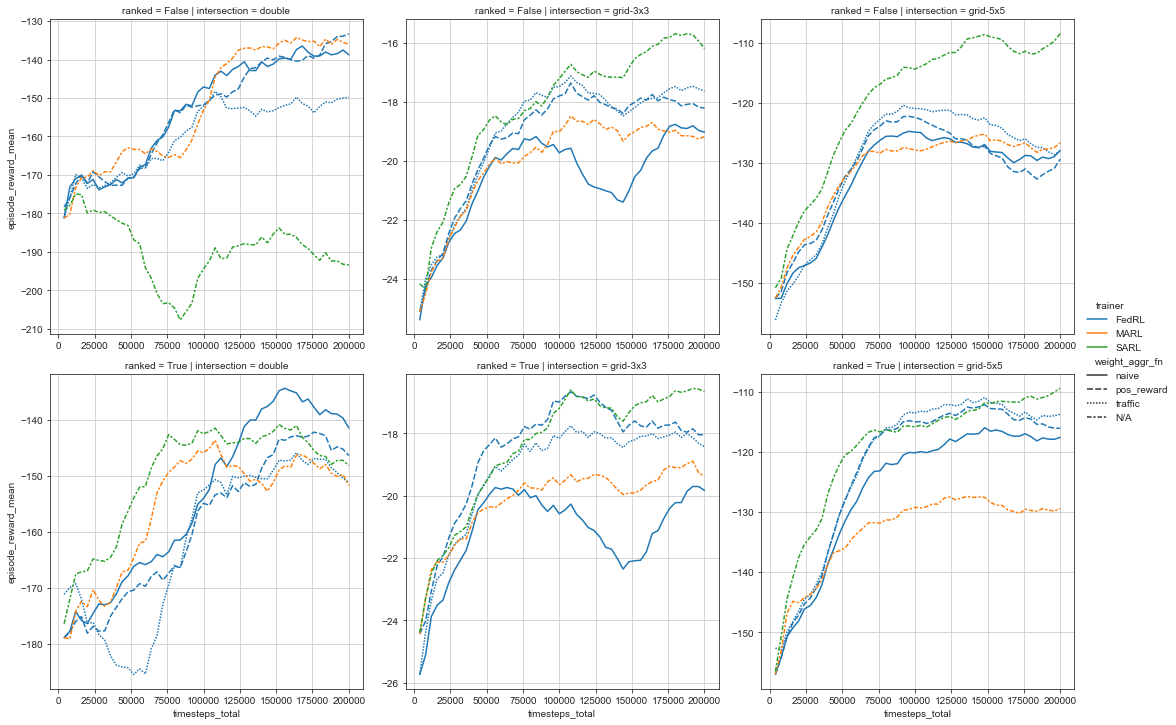

In [3]:
with sns.plotting_context(font_scale=2):
    sns.relplot(
        data=df, 
        kind="line", 
        x="timesteps_total", 
        y="episode_reward_mean", 
        hue="trainer", 
        style="weight_aggr_fn", 
        row="ranked", 
        col="intersection",
        facet_kws={"sharey": False, "sharex": False},
        ci=None
    )
    sns.despine(top=False, right=False, left=False, bottom=False)
    plt.savefig("rewards.pdf")
    plt.show()

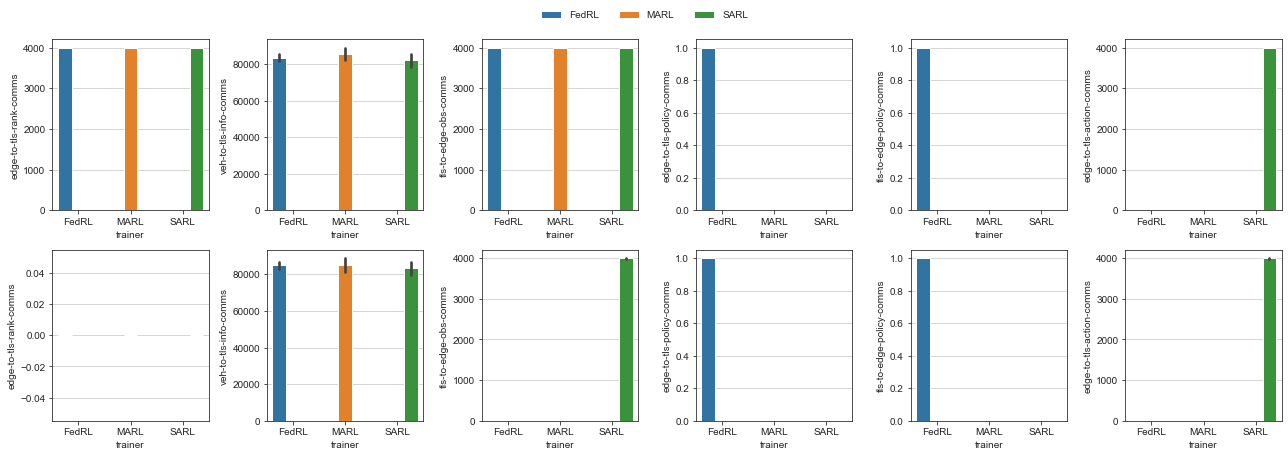

In [4]:
NROWS, NCOLS = 2, 6
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, sharex=False, sharey=False, figsize=(18, 6))

for col, comm_type in enumerate(COMM_TYPES):
    for row, ranked in enumerate([True, False]):
        sns.barplot(data=df.query(f"ranked == {ranked}"), x="trainer", y=comm_type, hue="trainer", ax=ax[row, col])
        

labels, handles = ax[NROWS-1, NCOLS-1].get_legend_handles_labels()
for col in range(6):
    for row in range(2):        
        ax[row, col].get_legend().remove()

fig.legend(labels, handles, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.0625), frameon=False)
plt.tight_layout()
plt.show()


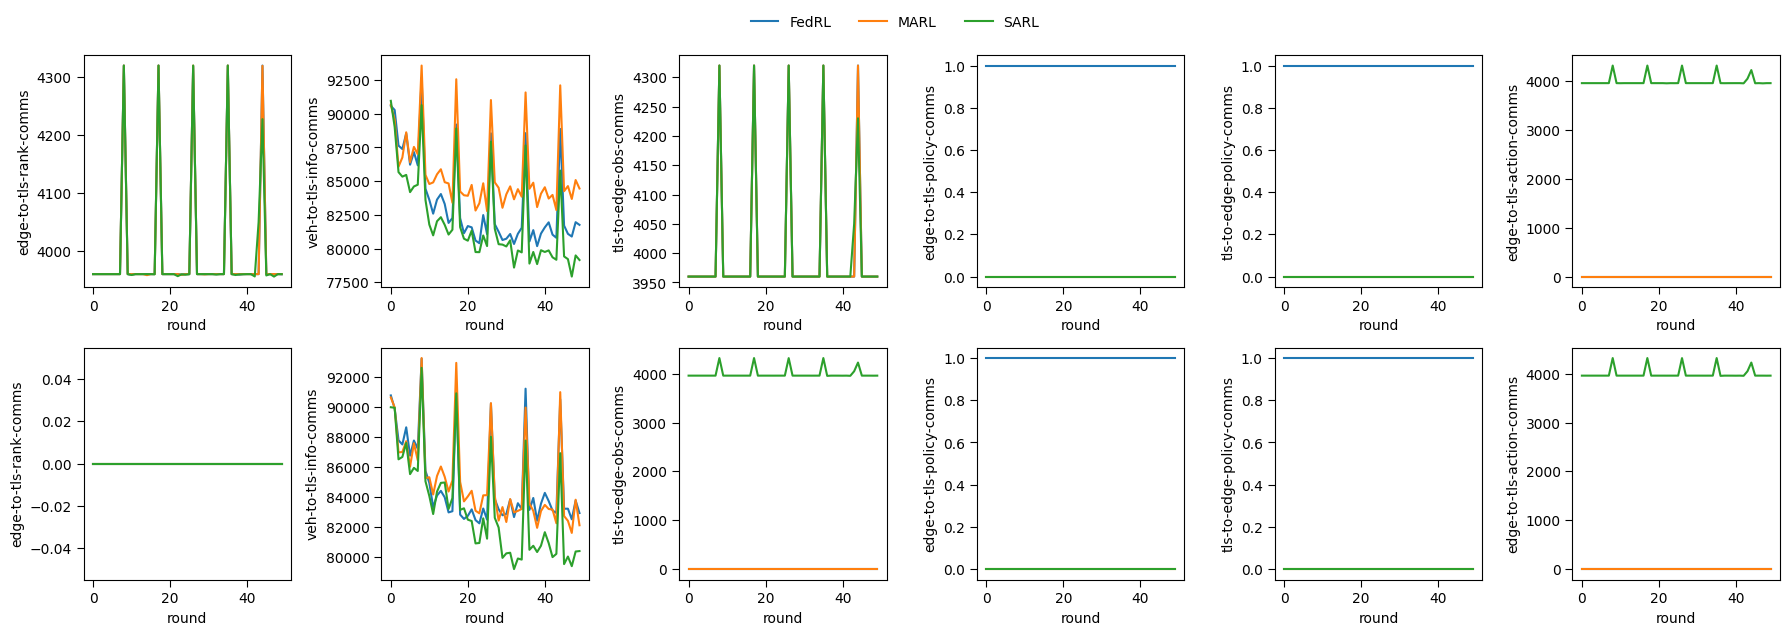

In [42]:
NROWS, NCOLS = 2, 6
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, sharex=False, sharey=False, figsize=(18, 6))

for col, comm_type in enumerate(COMM_TYPES):
    for row, ranked in enumerate([True, False]):
        sns.lineplot(data=df.query(f"ranked == {ranked}"), x="round", y=comm_type, hue="trainer", ci=None, ax=ax[row, col])
        

labels, handles = ax[NROWS-1, NCOLS-1].get_legend_handles_labels()
for col in range(6):
    for row in range(2):        
        ax[row, col].get_legend().remove()

fig.legend(labels, handles, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.0625), frameon=False)
plt.tight_layout()
plt.show()


In [5]:
def comm_df_fn(weights: dict=None) -> pd.DataFrame:
    if weights is None:
        weights = {}
    for comm_type in COMM_TYPES:
        if comm_type not in weights:
            weights[comm_type] = 1.0

    def fn(row):
        return sum(
            row[comm_type] * weights[comm_type] 
            for comm_type in COMM_TYPES
        )

    comm_df = df.copy()
    comm_df["weighted_comm_cost"] = df.apply(lambda row: fn(row), axis=1)
    return comm_df

In [6]:
print(COMM_TYPES)

{'edge-to-tls-rank-comms', 'veh-to-tls-info-comms', 'tls-to-edge-obs-comms', 'edge-to-tls-policy-comms', 'tls-to-edge-policy-comms', 'edge-to-tls-action-comms'}


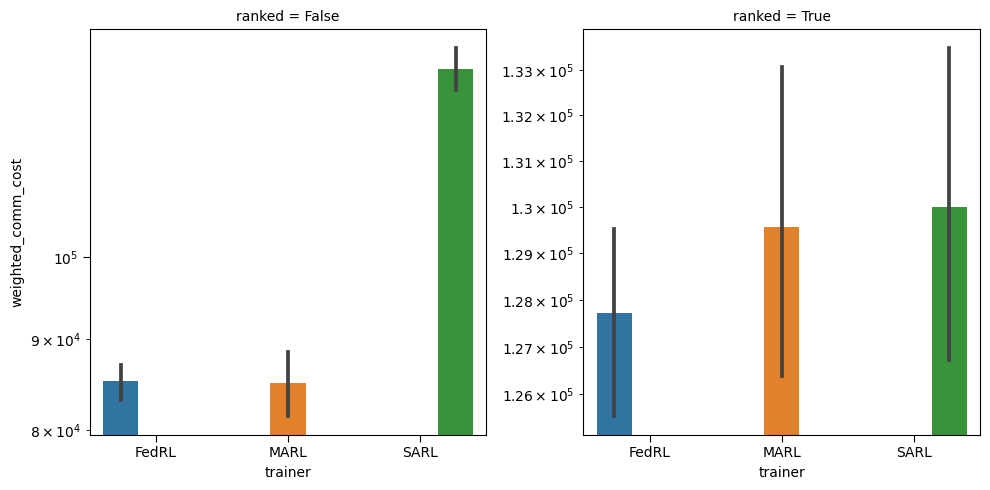

In [38]:
comm_weights = {
    'edge-to-tls-rank-comms':   1, 
    'tls-to-edge-obs-comms':    10, 
    'tls-to-edge-policy-comms': 150, 
    'edge-to-tls-policy-comms': 150, 
    'veh-to-tls-info-comms':    1, 
    'edge-to-tls-action-comms': 1
}

comm_df = comm_df_fn(comm_weights)
# comm_df.head()
sns.catplot(data=comm_df, kind="bar", col="ranked", x="trainer", y="weighted_comm_cost", hue="trainer", sharey=False)\
    .set(yscale="log")
sns.despine(top=False, right=False, left=False, bottom=False)
plt.tight_layout()
plt.show()

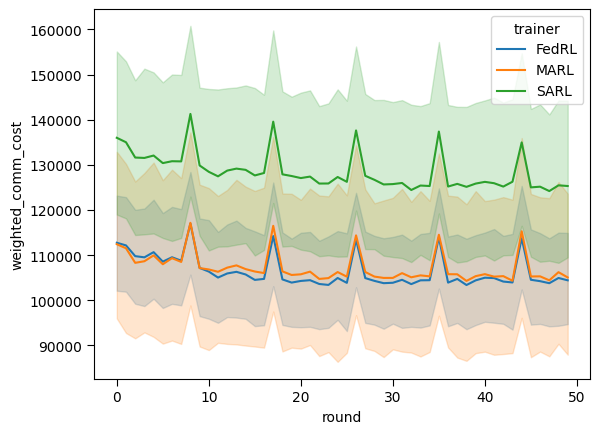

In [40]:
sns.lineplot(data=comm_df, x="round", y="weighted_comm_cost", hue="trainer")
plt.show()

In [7]:
df.query("trainer == 'SARL'")["tls-to-edge-obs-comms"].describe()

count    3600.00000
mean     3995.62000
std       108.10283
min      3941.00000
25%      3960.00000
50%      3960.00000
75%      3960.00000
max      4320.00000
Name: tls-to-edge-obs-comms, dtype: float64

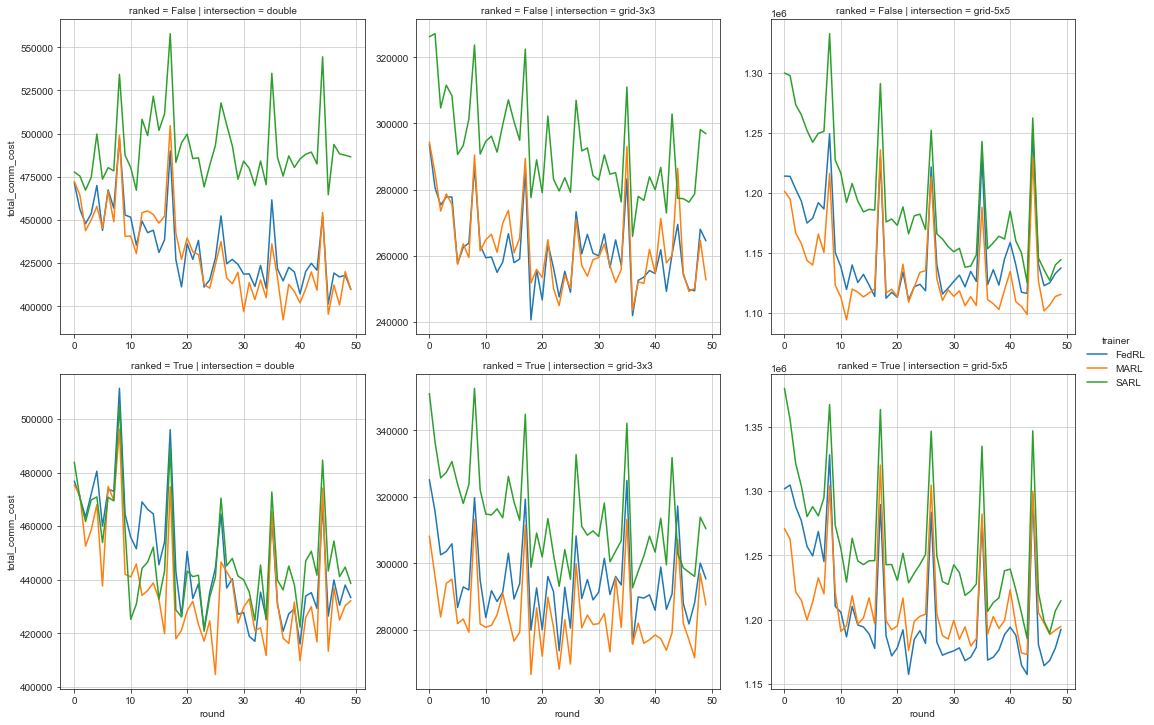

In [4]:
f = sns.relplot(
    data=df, 
    kind="line", 
    x="round", 
    y="total_comm_cost", 
    hue="trainer", 
    row="ranked", 
    col="intersection",
    facet_kws={"sharey": False, "sharex": False},
    ci=None,
    # style="weight_aggr_fn", 
)
sns.despine(top=False, right=False, left=False, bottom=False)
plt.savefig("comm_cost.pdf")
plt.show()

In [7]:
df["comm_type"].unique()

array(['edge-to-tls-policy-comms', 'tls-to-edge-policy-comms',
       'veh-to-tls-info-comms', 'edge-to-tls-rank-comms',
       'edge-to-tls-action-comms', 'tls-to-edge-obs-comms'], dtype=object)

In [8]:
df.query("ranked == True and intersection == 'grid-5x5' and comm_type == 'veh-to-tls-info-comms'")["comm_cost"].describe()

count    41625.000000
mean      7569.861093
std       5748.720828
min        563.000000
25%       3714.000000
50%       5096.000000
75%      11994.000000
max      35122.000000
Name: comm_cost, dtype: float64

In [15]:
# df.plot(kind="bar", x="trainer", y="edge-to-tls-policy-comms")
# plt.show()

df["tls-to-edge-obs-comms"].describe()

count    18000.000000
mean      1598.306500
std       1958.764225
min          0.000000
25%          0.000000
50%          0.000000
75%       3960.000000
max       4320.000000
Name: tls-to-edge-obs-comms, dtype: float64

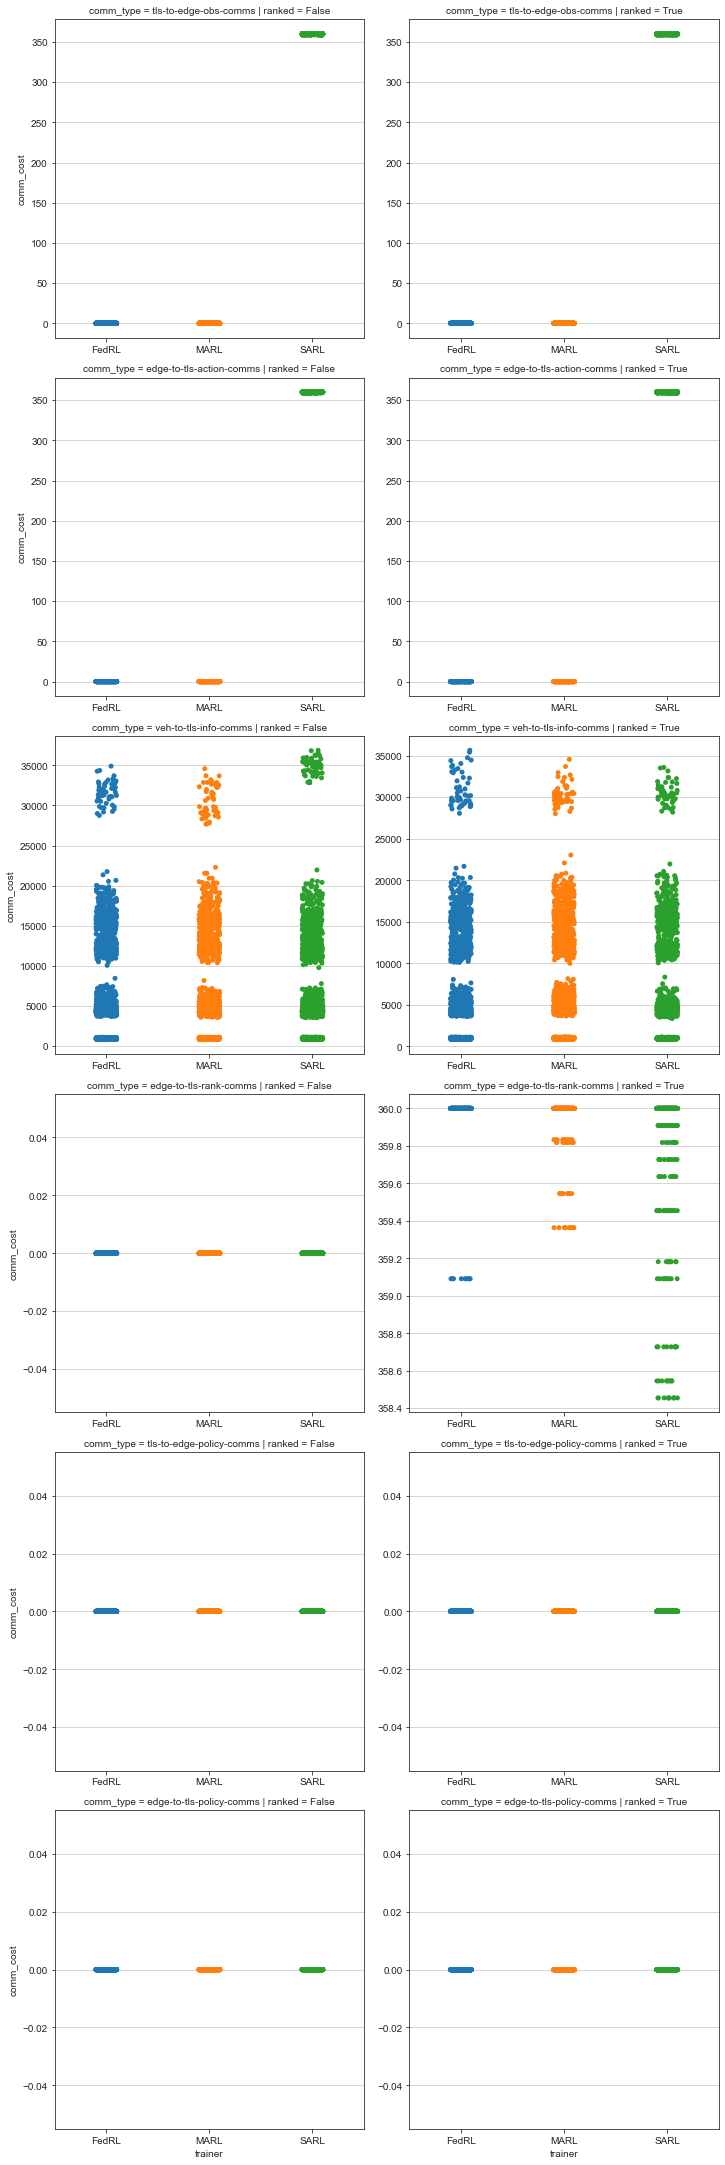

In [10]:
sns.catplot(
    data=df, 
    kind="strip", 
    x="trainer",
    y="comm_cost",
    # style="comm_type", 
    col="ranked",
    row="comm_type", 
    # col="trainer",
    hue="trainer",
    sharex=False,
    sharey=False,
    # markers=True,
    # facet_kws={"sharex": False, "sharey": False},
    # ci=None
)
sns.despine(top=False, right=False, left=False, bottom=False)
plt.show()

In [39]:
df.query("ranked == True and trainer == 'SARL' and comm_type == 'tls-to-edge-obs-comms'")["comm_cost"].unique()

array([360, 354, 359, 346, 356, 357, 358, 344, 353, 351, 350], dtype=int64)

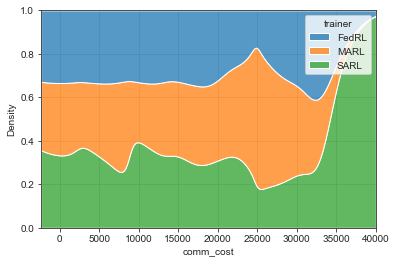

In [11]:
ax = sns.kdeplot(
    data=df.query("comm_type == 'veh-to-tls-info-comms'"),
    x="comm_cost",
    hue="trainer",
    multiple="fill"
)
plt.show()

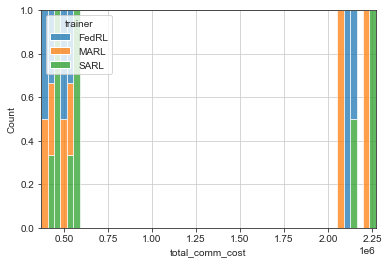

In [25]:
ax = sns.histplot(
    data=df,
    x="total_comm_cost",
    hue="trainer",
    multiple="fill"
)
plt.show()

In [ ]:
next(iter)